# German rents

This notebook parses average net rent data from the 2022 census and reconstructs the grid geometry (building it in memory is on order 100x faster than reading it from [the BKG file](https://gdz.bkg.bund.de/index.php/default/inspire/sonstige-inspire-themen/geographische-gitter-fur-deutschland-in-lambert-projektion-geogitter-inspire.html)).

Max Köhler/SWR DataLab


In [1]:
from matplotlib import pyplot as plt
from shapely.geometry import shape, Polygon
import pandas as pd
from pathlib import Path
import pyogrio
import geopandas as gp
import shapely as shp

from tqdm import tqdm
tqdm.pandas()

In [2]:
def read_chunks (path, chunksize=1000, mode="pd", read_options={}):
	print(f"Reading {path}...")
	s = Path(path).resolve()
	df = None
	r = 0
	
	if mode == "pd":
		total = sum(1 for row in open(s, 'r'))
		df = pd.DataFrame() 
		with tqdm(total=total, unit=" lines") as bar:
			for i, chunk in enumerate(pd.read_csv(s, chunksize=chunksize, **read_options)):
				df = pd.concat([df,chunk])
				if r + chunksize < total:
					r += chunksize
					bar.update(chunksize)
				else:
					bar.update(total - r)
	elif mode == "gp":
		total = pyogrio.read_info(s)["features"]
		print(f"{total} features found")
		
		# gp.read_file can't read in slices. When you set the "rows" parameter it loads the whole file anyway.
		# The best we can do is load the whole file at once, so we'll do that until the library improves
		# See also: https://github.com/geopandas/geopandas/issues/2359
		df = gp.read_file(s)
	return df

In [5]:
countries_raw = gp.read_file("./data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

In [6]:
resolutions = {
	"10km": 10_000,
	"1km": 1_000,
	"100m": 100
}

data = {}

for key, cell_extent in resolutions.items():
	data[key]	= read_chunks(
		path=f"./data/Zensus2022_Durchschn_Nettokaltmiete/Zensus2022_Durchschn_Nettokaltmiete_{key}-Gitter.csv",
		mode="pd",
		chunksize=10_000,
		read_options={"delimiter": ";", "decimal": ","}
	)

Reading ./data/Zensus2022_Durchschn_Nettokaltmiete/Zensus2022_Durchschn_Nettokaltmiete_10km-Gitter.csv...


100%|██████████| 3806/3806 [00:00<00:00, 347048.15 lines/s]


Reading ./data/Zensus2022_Durchschn_Nettokaltmiete/Zensus2022_Durchschn_Nettokaltmiete_1km-Gitter.csv...


100%|██████████| 136025/136025 [00:00<00:00, 549952.62 lines/s]


Reading ./data/Zensus2022_Durchschn_Nettokaltmiete/Zensus2022_Durchschn_Nettokaltmiete_100m-Gitter.csv...


100%|██████████| 1287343/1287343 [00:04<00:00, 297140.02 lines/s]


In [7]:
data["10km"]

,GITTER_ID_10km,x_mp_10km,y_mp_10km,durchschnMieteQM,werterlaeuternde_Zeichen
0,CRS3035RES10000mN2690000E4330000,4335000,2695000,6.67,NaN
1,CRS3035RES10000mN2690000E4340000,4345000,2695000,8.14,NaN
2,CRS3035RES10000mN2690000E4410000,4415000,2695000,8.61,NaN
3,CRS3035RES10000mN2700000E4320000,4325000,2705000,7.87,NaN
4,CRS3035RES10000mN2700000E4330000,4335000,2705000,7.55,NaN
...,...,...,...,...,...
3800,CRS3035RES10000mN3530000E4230000,4235000,3535000,5.90,NaN
3801,CRS3035RES10000mN3530000E4240000,4245000,3535000,5.59,NaN
3802,CRS3035RES10000mN3530000E4250000,4255000,3535000,6.59,NaN
3803,CRS3035RES10000mN3540000E4210000,4215000,3545000,12.81,NaN


In [8]:
# https://epsg.io/3035

for key, cell_extent in resolutions.items():
	print(f"Building geometry at {key} resolution...")
	data[key]["geometry"] = data[key].progress_apply(
		lambda x: shp.geometry.box(
			minx=x[f"x_mp_{key}"] - cell_extent * .5,
			miny=x[f"y_mp_{key}"] - cell_extent * .5,
			maxx=x[f"x_mp_{key}"] + cell_extent * .5,
			maxy=x[f"y_mp_{key}"] + cell_extent * .5),
		axis=1)

	data[key] = gp.GeoDataFrame(data[key], geometry="geometry", crs="EPSG:3035").to_crs(epsg=4326)
	data[key][["durchschnMieteQM", "geometry"]].to_file(f"./tmp/rent_{key}.geojson")

Building geometry at 10km resolution...


100%|██████████| 3805/3805 [00:00<00:00, 16806.19it/s]


Building geometry at 1km resolution...


100%|██████████| 136024/136024 [00:06<00:00, 22535.88it/s]


Building geometry at 100m resolution...


100%|██████████| 1287342/1287342 [00:59<00:00, 21780.98it/s]


In [9]:
bounding_box = (5.25,47,15.5,55.25)
countries = countries_raw.set_crs(epsg=4326)

map_extent = gp.GeoDataFrame(
    data={"geometry": [
        Polygon([
            (bounding_box[0], bounding_box[1]),
            (bounding_box[2], bounding_box[1]),
            (bounding_box[2], bounding_box[3]),
            (bounding_box[0], bounding_box[3]),
		])
	]},
    geometry="geometry",
    crs='EPSG:4326'
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


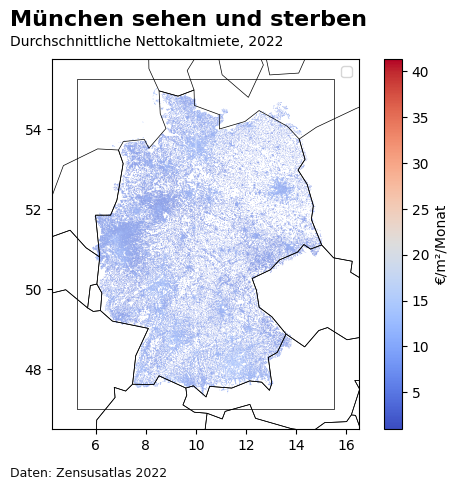

In [11]:
fig, ax = plt.subplots()

ax.set_xlim(bounding_box[0] -1, bounding_box[2] + 1)
ax.set_ylim(bounding_box[1] -.5, bounding_box[3] + .5)

countries.plot(ax=ax, color="none", edgecolor="black", zorder=200, lw=.5)
map_extent.plot(ax=ax, color='none', edgecolor="black",lw=.5, zorder=100)
data["10km"].plot(ax=ax,cmap="coolwarm" ,column="durchschnMieteQM", zorder=40, legend=True, legend_kwds={"label": "€/m²/Monat"})

ax.text(x=.2, y=.95, s="München sehen und sterben", transform=fig.transFigure, ha='left', fontsize=16, weight='heavy', alpha=1, linespacing=5)
ax.text(x=.2, y=.9075, s="Durchschnittliche Nettokaltmiete, 2022", transform=fig.transFigure, ha='left', fontsize=10, alpha=1)
ax.text(x=.2, y=0.01, s="Daten: Zensusatlas 2022", transform=fig.transFigure, ha='left', fontsize=9, alpha=.95, linespacing=1.35)
ax.legend()
plt.show()